In [16]:
import sys, os
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import scipy.stats as stats

#import pyOptimalEstimation as pyOE
#sys.path.append('../src')
#from utils import tiepoint

from simple_oo import *

import utils

In [3]:
print(sys.path)

['C:\\Users\\fnifd\\Documents\\BachelorProject\\observation_operator', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\python38.zip', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\DLLs', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\lib', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor', '', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\lib\\site-packages', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\lib\\site-packages\\win32', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\lib\\site-packages\\win32\\lib', 'C:\\Users\\fnifd\\anaconda3\\envs\\Bachelor\\lib\\site-packages\\Pythonwin', '../src']


Let's call our model y = f(x). x is the input to our forward function, f, which is the simple model or the smrt model and y is brightness temperatures. To use pyOE we need to must find the following

 * x_a :  prior information of state x.
    
    
* S_a :  covariance matrix of state x.
    
    
* S_y :  covariance matrix of measurement y.


Hint: pyOptimalEstimation likes pandas arrays

# X: Covariance matrix and mean

Load data for one day and use this data to produce mean and covariances for x vector. (Should maybe be based on measurements over time and not space?)

In [1]:
# Path to data file
f_path = os.path.join(utils.DATA_RAW_PATH, "iceh_inst.1996-12-02-00000.nc")
# Get data array
st = utils.get_data_var_from_netCDF(f_path = f_path, var_name = 'Tsfc') + 273.15
sd = utils.get_data_var_from_netCDF(f_path = f_path, var_name = 'hs')
id = utils.get_data_var_from_netCDF(f_path = f_path, var_name = 'hi')
ic = utils.get_data_var_from_netCDF(f_path = f_path, var_name = 'aice')
# Set ice type
ice_type = 'firstyear'
# Set ice concentration limit
ic_limit = 0.9
st[ic < ic_limit] = np.nan
sd[ic < ic_limit] = np.nan
id[ic < ic_limit] = np.nan
ic[ic < ic_limit] = np.nan

NameError: name 'os' is not defined

In [3]:
x_vars = ['st', 'sd', 'id', 'ic']

In [4]:
x  = np.full([1491*1115,4], np.nan)
x[:,0] = st.flatten()
x[:,1] = sd.flatten()
x[:,2] = id.flatten()
x[:,3] = ic.flatten()
x = pd.DataFrame(x)
x.columns = ['%s' % (i) for i in x_vars]

In [5]:
S_a = x.cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
x_mean = x.mean().rename_axis('state', axis=0)
S_a, x_mean

(stateT         st        sd        id        ic
 state                                          
 st      63.286140 -0.298669 -4.189868 -0.042664
 sd      -0.298669  0.007362  0.056064 -0.000153
 id      -4.189868  0.056064  0.913962  0.003744
 ic      -0.042664 -0.000153  0.003744  0.000838,
 state
 st    251.267178
 sd      0.172009
 id      1.691988
 ic      0.978599
 dtype: float64)

# Define forward operator

In [6]:
def forwardRT(x):
    Tbv, Tbh = tiepoint(x[0], x[1], x[2], x[3])
    return np.concatenate((Tbv, Tbh))

# Y: Covariance

Load some tb data and make a covariance matrix. For now I have froced the full matrix except the variances to 0.

In [7]:
f_name = 'tbs_simple_squashed.nc'
ds_simple = xr.open_dataset(os.path.join(utils.DATA_PROCESSED_PATH, f_name))

In [8]:
ds_simple

<xarray.Dataset>
Dimensions:    (frequency: 5, i: 186, j: 249)
Coordinates:
  * frequency  (frequency) object '6Ghz' '10Ghz' '18Ghz' '36Ghz' '89Ghz'
    TLAT       (j, i) float32 ...
    TLON       (j, i) float32 ...
Dimensions without coordinates: i, j
Data variables:
    tbv        (j, i, frequency) float32 ...
    tbh        (j, i, frequency) float32 ...
    FYarea     (j, i) float32 ...
Attributes:
    description:  Temperature brightnesses generated by the smrt model (test).

In [9]:
freq =['06Ghz', '10Ghz', '18Ghz', '36Ghz', '89Ghz']

In [10]:
tbv = np.full([186*249,5], np.nan)
tbh = np.full([186*249,5], np.nan)
for i, f in enumerate(ds_simple['frequency'].values):
    tbv[:,i] = ds_simple['tbv'].sel(frequency = f).values.flatten()
    tbh[:,i] = ds_simple['tbh'].sel(frequency = f).values.flatten()

tbv = pd.DataFrame(tbv)
tbh = pd.DataFrame(tbh)
tbv.columns = ['v%s' % (i) for i in freq]
tbh.columns = ['h%s' % (i) for i in freq]
Y = pd.concat((tbv, tbh), axis=1)
#Y = Y.reindex(sorted(Y.columns), axis=1)

In [11]:
S_y = Y.cov()
y_err = np.diagonal(S_y)
# For all elements except the diagonals to 0
S_y = (pd.DataFrame(np.diag(y_err), columns = S_y.columns.values, index = S_y.index.values)
.rename_axis('state', axis=0).rename_axis('stateT', axis=1))

In [12]:
S_y

stateT,v06Ghz,v10Ghz,v18Ghz,v36Ghz,v89Ghz,h06Ghz,h10Ghz,h18Ghz,h36Ghz,h89Ghz
state,,,,,,,,,,
v06Ghz,1817.917014,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
v10Ghz,0.000000,1499.258014,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
v18Ghz,0.000000,0.000000,722.884248,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
v36Ghz,0.000000,0.000000,0.000000,331.556153,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
v89Ghz,0.000000,0.000000,0.000000,0.000000,553.48446,0.000000,0.000000,0.000000,0.000000,0.000000
h06Ghz,0.000000,0.000000,0.000000,0.000000,0.00000,4771.582026,0.000000,0.000000,0.000000,0.000000
h10Ghz,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4279.535158,0.000000,0.000000,0.000000
h18Ghz,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2719.359388,0.000000,0.000000
h36Ghz,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1344.226736,0.000000


# Prepare retrieval

Covariance matrices are not allowed to be singular

In [13]:
try:
    pyOE.invertMatrix(S_a)
    print('S_a not singular, all good')
except Exception as err:
    traceback.print_tb(err.__traceback__)
try:
    pyOE.invertMatrix(S_y)
    print('S_y not singular, all good')
except Exception as err:
    traceback.print_tb(err.__traceback__)

S_a not singular, all good
S_y not singular, all good


In [14]:
y_vars = S_y.columns.values
print('y_vars:\n', y_vars)
print('x_vars:\n', x_vars)

y_vars:
 ['v06Ghz' 'v10Ghz' 'v18Ghz' 'v36Ghz' 'v89Ghz' 'h06Ghz' 'h10Ghz' 'h18Ghz'
 'h36Ghz' 'h89Ghz']
x_vars:
 ['st', 'sd', 'id', 'ic']


We make some test data, y, from some data, x, that we know

In [15]:
x_truth = [st[1000,500], sd[1000,500], id[1000,500], ic[1000,500]]
x_truth = pd.Series(x_truth, index = x_vars)
y_obs = forwardRT(x_truth)
y_obs = pd.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))
y_obs

v06Ghz    242.756336
v10Ghz    237.851797
v18Ghz    221.459505
v36Ghz    188.782142
v89Ghz    185.521555
h06Ghz    214.442386
h10Ghz    208.773733
h18Ghz    195.909655
h36Ghz    174.207210
h89Ghz    175.677336
dtype: float64

We now have our test data, and the covariance matrices. x_a is simply set to x_mean. 

In [16]:
x_a = x_mean # Jeg ved ikke hvad x_a skal repræsentere, men det er sådan de gør i deres eksempel.

In [17]:
oe_ref = pyOE.optimalEstimation(
    x_vars, # state variable names 
    x_a,  # a priori 
    S_a, # a priori uncertainty 
    y_vars,  # measurement variable names 
    y_obs, # observations
    S_y, # observation uncertainty
    forwardRT, # forward Operator
    x_truth = x_truth # optional and only used to validate final results
)

# Run retrieval

In [18]:
oe_ref.doRetrieval()

0.05 s, iteration 1, degrees of freedom: 0.94 of 4, converged (x-space):  0.000
0.07 s, iteration 2, degrees of freedom: 0.94 of 4, done.  0.000


True

In [19]:
oe_ref.x_op, x_truth

(st    246.910136
 sd      0.238281
 id      2.281134
 ic      0.978313
 dtype: float64,
 st    243.034103
 sd      0.243126
 id      2.442965
 ic      0.950638
 dtype: float64)

In [20]:
print(oe_ref.S_op)

           st        sd        id        ic
st  39.791510  0.053750 -1.144489 -0.041487
sd   0.053750  0.001696  0.007892 -0.000178
id  -1.144489  0.007892  0.475562  0.003773
ic  -0.041487 -0.000178  0.003773  0.000827


/home/atj/anaconda3/envs/smrt/lib/python3.8/site-packages/pyOptimalEstimation/pyOEcore.py:1120: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)


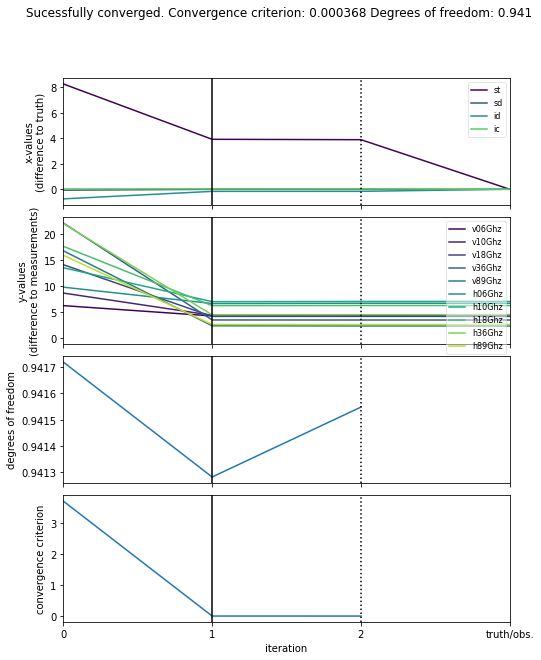

In [21]:
fig = oe_ref.plotIterations(legend=True, mode='difference')

# Get help

In [22]:
help(oe_ref)

Help on optimalEstimation in module pyOptimalEstimation.pyOEcore object:

class optimalEstimation(builtins.object)
 |  optimalEstimation(x_vars, x_a, S_a, y_vars, y_obs, S_y, forward, x_truth=None, b_vars=[], b_p=[], S_b=[[]], x_lowerLimit={}, x_upperLimit={}, useFactorInJac=False, gammaFactor=None, disturbance=0.1, convergenceFactor=10, convergenceTest='x', forwardKwArgs={})
 |  
 |  The core optimalEstimation class, which contains all required parameters.
 |  See [1]_ for an extensive introduction into Optimal Estimation theory.
 |  
 |  Parameters
 |  ----------
 |  x_vars : list of str
 |      names of the elements of state vector x.
 |  x_a : pd.Series or list or np.ndarray
 |      prior information of state x.
 |  S_a : pd.DataFrame or list or np.ndarray
 |      covariance matrix of state x.
 |  y_vars : list of str
 |      names of the elements of state vector x
 |  y_obs : pd.Series or list or np.ndarray
 |      observed measurement vector y.
 |  S_y : pd.DataFrame or list or n